In [1]:
import os
import sys

sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch

import common_config

In [2]:
#TODO: Double-check runtime is in seconds

In [3]:
common_config.figure_journal_basic()

color_palette = {
    "CPU: AMD Threadripper Pro 7975WX": common_config.rsc_grey,
    "GPU: H200": common_config.rsc_lightgreen,
    "GPU: B200": common_config.rsc_darkgreen,
    "GPU: RTX Pro 6000": common_config.rsc_turquise,
}

### Load and prepare data

In [4]:
def create_column_mapping(run_columns):
    return {
        col: (
            "CPU: AMD Threadripper Pro 7975WX" if col.startswith("AMD")
            else "GPU: RTX Pro 6000" if col.startswith("RTX")
            else "GPU: H200" if col.startswith("H200")
            else "GPU: B200" if col.startswith("B200")
            else col.rsplit(" - ", 1)[0]
        )
        for col in run_columns
    }

def melt_runtime_dataframe(df, run_columns, id_column, column_mapping, runtime_col_name="Runtime"):
    return pd.concat([
        df[[id_column, col]].rename(columns={col: runtime_col_name})
        .assign(Machine=column_mapping[col], Run=col.split(" - ")[-1])
        for col in run_columns
    ], ignore_index=True)

In [5]:
df = pd.read_csv("data/runtime_1million_cells.csv")
# Select only Run1, Run2, Run3 columns (exclude Mean and Speedup columns)
run_columns = [col for col in df.columns if col.endswith("- Run1") or col.endswith("- Run2") or col.endswith("- Run3")]
df = df[["Function"] + run_columns].copy()

column_mapping = create_column_mapping(run_columns)
df_melted = melt_runtime_dataframe(df, run_columns, "Function", column_mapping)

exclude_rows = ["PP-Time", "Total-Notebook", "Total-Notebook IGraph"]
df_melted = df_melted[~df_melted["Function"].isin(exclude_rows)]

df_melted = df_melted[["Function", "Machine", "Run", "Runtime"]]
df_melted = df_melted.rename(columns={"Runtime": "Runtime (s)"})
df_melted["Runtime (min)"] = df_melted["Runtime (s)"] / 60

# Remove leidenalg Leiden clustering, we will just show Leiden clustering with iGraph
df_melted = df_melted[df_melted["Function"] != "Leiden"]
df_melted["Function"] = df_melted["Function"].replace({
    "QC": "Quality control",
    "HVG (Seuratv3)": "Highly\nvariable genes",
    "Regress Out": "Regress out",
    "scale": "Scale",
    "Diffusion Map": "Diffusion map",
    "IGraph": "Leiden clustering",
})

machine_order = list(color_palette.keys())
df_melted["Machine"] = pd.Categorical(df_melted["Machine"], categories=machine_order, ordered=True)

df_melted.head(5)

,Function,Machine,Run,Runtime (s),Runtime (min)
0,Quality control,CPU: AMD Threadripper Pro 7975WX,Run1,23.90,0.398333
1,Highly\nvariable genes,CPU: AMD Threadripper Pro 7975WX,Run1,17.60,0.293333
2,Regress out,CPU: AMD Threadripper Pro 7975WX,Run1,5.68,0.094667
3,Scale,CPU: AMD Threadripper Pro 7975WX,Run1,11.10,0.185000
4,PCA,CPU: AMD Threadripper Pro 7975WX,Run1,149.00,2.483333


In [6]:
df_harmony = pd.read_csv("data/runtime_harmony.csv")

# Select only Run1, Run2, Run3 columns (exclude Mean and Speedup columns)
run_columns = [col for col in df_harmony.columns if col.endswith("- Run1") or col.endswith("- Run2") or col.endswith("- Run3")]
df_harmony_runs = df_harmony[["Datasize"] + run_columns].copy()

column_mapping = create_column_mapping(run_columns)
df_harmony_melted = melt_runtime_dataframe(df_harmony_runs, run_columns, "Datasize", column_mapping, runtime_col_name="Runtime (s)")

size_dict = {213_082: "200k", 2_432_775: "2M", 11_441_407: "11M"}
def format_datasize(x):
    cells, genes = x.strip("()").split(",")
    datasize = f"{int(cells):,} cells; {int(genes):,} genes"
    function = f"Harmony ({size_dict[int(cells)]} cells)"
    return datasize, function
df_harmony_melted["Datasize"], df_harmony_melted["Function"] = zip(*df_harmony_melted["Datasize"].apply(format_datasize))

df_harmony_melted["Runtime (min)"] = df_harmony_melted["Runtime (s)"].astype(float) / 60

df_harmony_melted.head(5)

,Datasize,Runtime (s),Machine,Run,Function,Runtime (min)
0,"213,082 cells; 100 genes",176.0,CPU: AMD Threadripper Pro 7975WX,Run1,Harmony (200k cells),2.933333
1,"2,432,775 cells; 100 genes",987.0,CPU: AMD Threadripper Pro 7975WX,Run1,Harmony (2M cells),16.450000
2,"11,441,407 cells; 50 genes",7200.0,CPU: AMD Threadripper Pro 7975WX,Run1,Harmony (11M cells),120.000000
3,"213,082 cells; 100 genes",177.0,CPU: AMD Threadripper Pro 7975WX,Run2,Harmony (200k cells),2.950000
4,"2,432,775 cells; 100 genes",987.0,CPU: AMD Threadripper Pro 7975WX,Run2,Harmony (2M cells),16.450000


### Cumulative runtime

/var/folders/zz/30xy72gx11z33hw95rnnfy1r0000gp/T/ipykernel_50479/543836589.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_cumulative["Cumulative Runtime (min)"] = df_cumulative.groupby(["Machine", "Run"])["Runtime (min)"].cumsum()


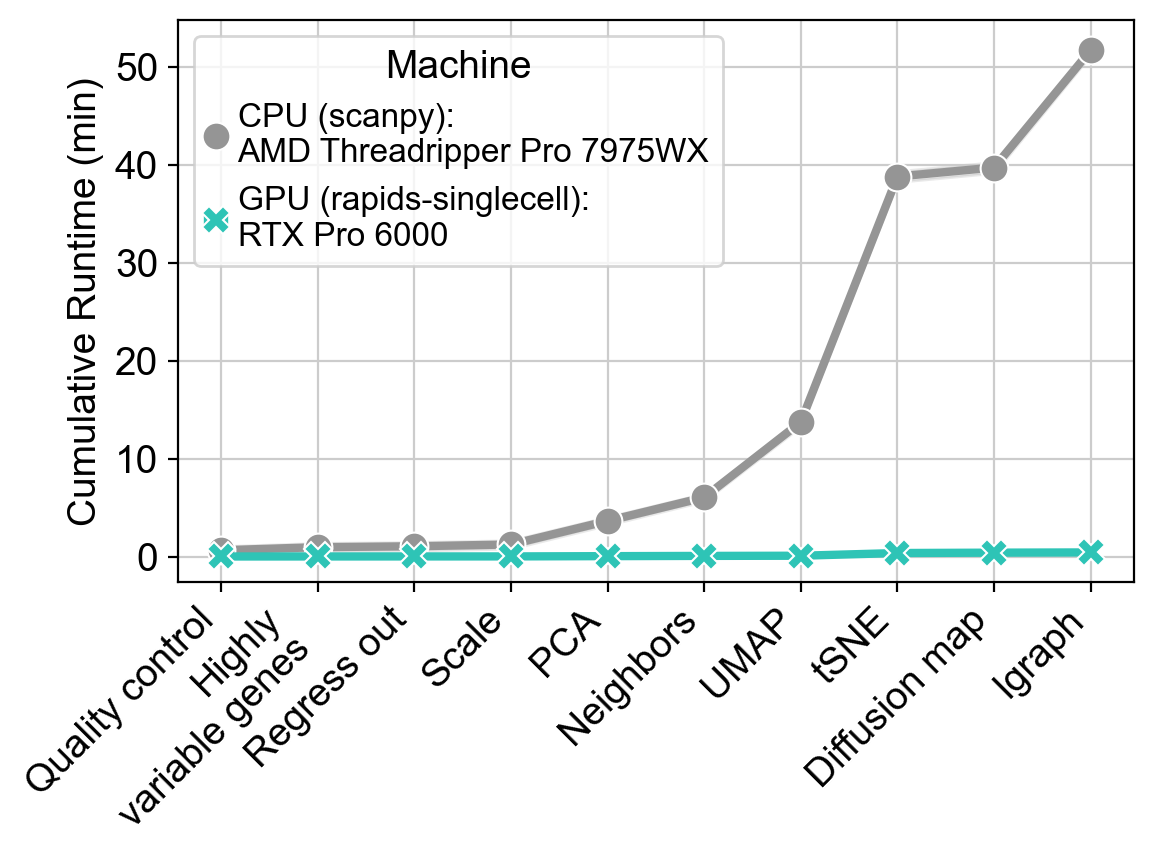

In [7]:
df_cumulative = df_melted.copy()
# Only show CPU and RTX GPU (highest speedup)
df_cumulative = df_cumulative[df_cumulative["Machine"].isin(["CPU: AMD Threadripper Pro 7975WX", "GPU: RTX Pro 6000"])]
df_cumulative["Cumulative Runtime (min)"] = df_cumulative.groupby(["Machine", "Run"])["Runtime (min)"].cumsum()

# Ensure Function order matches the original order
function_order = df_melted["Function"].unique()
df_cumulative["Function"] = pd.Categorical(df_cumulative["Function"], categories=function_order, ordered=True)
df_cumulative["Machine"] = df_cumulative["Machine"].astype("category").cat.remove_unused_categories()

plt.figure(figsize=(6, 4.5))
ax = sns.lineplot(
    data=df_cumulative,
    x="Function",
    y="Cumulative Runtime (min)",
    hue="Machine",
    style="Machine",
    markers=True,
    dashes=False,
    palette=color_palette,
    linewidth=3,
    markersize=10,
    estimator="mean",
    errorbar="sd",
    err_style="band",
    legend=True,
)

label_map = {
    "CPU: AMD Threadripper Pro 7975WX": "CPU (scanpy):\nAMD Threadripper Pro 7975WX",
    "GPU: RTX Pro 6000": "GPU (rapids-singlecell):\nRTX Pro 6000",
}
handles, labels = ax.get_legend_handles_labels()
new_labels = [label_map.get(l, l) for l in labels]
ax.legend(handles, new_labels, title="Machine", fontsize=12)

plt.xticks(range(len(function_order)), function_order, rotation=45, ha="right")
plt.ylabel("Cumulative Runtime (min)")
plt.xlabel("")
plt.tight_layout()
plt.savefig("figs/runtime_1million_cells.png", format="png")
plt.savefig("figs/runtime_1million_cells.svg", format="svg")

### Speedup

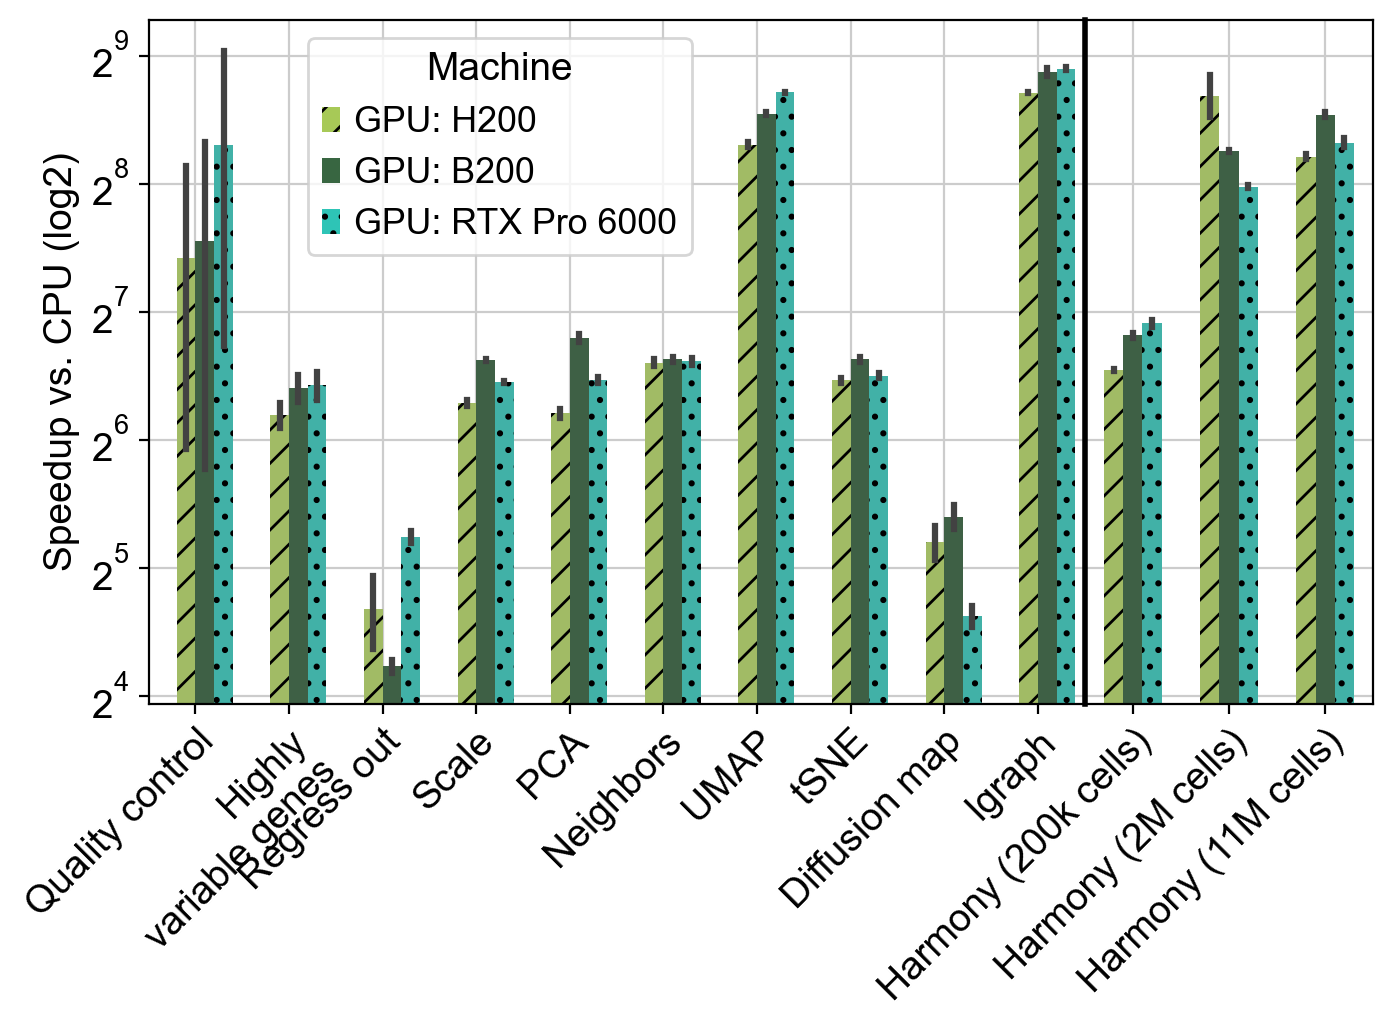

In [8]:
def compute_speedup(
    df_melted_in: pd.DataFrame,
    id_col: str = "Function",
    id_order = None,
    cpu_machine: str = "CPU: AMD Threadripper Pro 7975WX",
    runtime_col: str = "Runtime (min)",
    machine_col: str = "Machine",
    run_col: str = "Run",
):
    cpu_runtime = df_melted_in[df_melted_in[machine_col] == cpu_machine].set_index([id_col, run_col])[runtime_col]

    df_speedup = df_melted_in[df_melted_in[machine_col] != cpu_machine].copy()
    df_speedup["CPU_Runtime"] = df_speedup.set_index([id_col, run_col]).index.map(lambda x: cpu_runtime.loc[x])
    df_speedup["Speedup"] = df_speedup["CPU_Runtime"] / df_speedup[runtime_col]

    df_speedup[id_col] = pd.Categorical(df_speedup[id_col], categories=id_order, ordered=True)
    df_speedup = df_speedup.sort_values([id_col, machine_col, run_col])

    return df_speedup

def apply_bar_hatching(ax, machine_order, hatch_map, n_cats):
    for bar, machine in zip(ax.patches, [m for m in machine_order for _ in range(n_cats)]):
        bar.set_hatch(hatch_map[machine])
        bar.set_rasterized(True)

# Regular speedup (1M cells)
function_order = df_melted["Function"].unique()
df_speedup = compute_speedup(df_melted, id_col="Function", id_order=function_order)

# Harmony speedup
function_harmony_order = df_harmony_melted["Function"].unique()
df_harmony_speedup = compute_speedup(df_harmony_melted, id_order=function_harmony_order)


fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(7.85, 4.5), sharey=True, gridspec_kw={"width_ratios": [6, 1.85], "wspace": 0.0})

machine_order = list(df_speedup["Machine"].unique())
hatches = ["//", "", ".."]
hatch_map = dict(zip(machine_order, hatches))

# Left panel: regular speedup
sns.barplot(
    data=df_speedup,
    x="Function",
    y="Speedup",
    hue="Machine",
    palette=color_palette,
    errorbar="sd",
    ax=ax_left,
)
ax_left.set_yscale("log", base=2)

apply_bar_hatching(ax_left, machine_order, hatch_map, len(function_order))

legend_handles = [
    mpatches.Patch(
        facecolor=color_palette[machine],
        hatch=hatch_map[machine],
        label=machine,
    )
    for machine in machine_order
]
ax_left.legend(handles=legend_handles, title="Machine", loc="upper center", bbox_to_anchor=(0.375, 1.00))

ax_left.set_xlabel("")
ax_left.set_ylabel("Speedup vs. CPU (log2)")
plt.setp(ax_left.get_xticklabels(), rotation=45, ha="right", va="top", rotation_mode="anchor")
ax_left.set_axisbelow(True)
ax_left.grid(True)

# Right panel: harmony speedup
sns.barplot(
    data=df_harmony_speedup,
    x="Function",
    y="Speedup",
    hue="Machine",
    hue_order=machine_order,
    palette=color_palette,
    errorbar="sd",
    ax=ax_right,
    width=0.6, #Make bars narrower
)
ax_right.set_yscale("log", base=2)

apply_bar_hatching(ax_right, machine_order, hatch_map, len(function_harmony_order))

ax_right.legend_.remove()
ax_right.set_xlabel("")
ax_right.set_ylabel("")
plt.setp(ax_right.get_xticklabels(), rotation=45, ha="right", va="top", rotation_mode="anchor")
ax_right.tick_params(axis="y", left=False, labelleft=False)
ax_right.set_axisbelow(True)
ax_right.grid(True)

ax_left.spines["right"].set_visible(False)
ax_right.spines["left"].set_visible(True)
ax_right.spines["left"].set_linewidth(2)

fig.subplots_adjust(wspace=0.0)
fig.savefig("figs/speedup_1million_harmony_log2.png", format="png")
fig.savefig("figs/speedup_1million_harmony_log2.svg", format="svg")